# 作業重點:

(1)以, Adam, 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

(2)以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

# 作業目標:
    
    取得各種優化器的運算結果

In [47]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras import optimizers


In [48]:
#Blas GEMM launch failed , 避免動態分配GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


In [49]:
#為了解決 model.fit 當掉問題
#（OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.）
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [50]:

'''
   宣告並設定
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   
''' 

batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'


In [51]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [52]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


In [53]:
# 是否要做資料處理
if not data_augmentation:
    print('Not using data augmentation.')

else:
    print('Using real-time data augmentation.')
    print('')
        
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)


Using real-time data augmentation.



In [69]:
# 繪圖函式
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_acc(history_dict, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']

    epochs = range(1, len(loss_values) + 1)

    ax1.plot(epochs, loss_values, 'k:', label='training loss')
    ax1.plot(epochs, val_loss_values, 'b--', label='validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title(title)

    ax2.plot(epochs, acc_values, 'k:', label='training accuracy')
    ax2.plot(epochs, val_acc_values, 'b--', label='validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.set_title(title)
    plt.tight_layout()
    plt.show()

In [61]:
#    第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
 
model = Sequential()

#   第二步：構建網絡層
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense( 10)) # 輸出結果是10個類別，所以維度是10   
model.add(Activation('softmax')) # 最後一層用softmax作為激活函數

In [62]:
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：26490


In [63]:
# 輸出模型摘要資訊
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_85 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_86 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 15, 15, 16)        4624      
__________

## 作業 1 : 以 Adam 為例, 調整 batch_size, epoch , 觀察accurancy, loss 的變化

In [66]:
#第三步編譯
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [67]:
#第四步：訓練
'''
.fit的一些參數
   batch_size：對總的樣本數進行分組，每組包含的樣本數量
   epochs ：訓練次數
   shuffle：是否把數據隨機打亂之後再進行訓練
   validation_split：拿出百分之多少用來做交叉驗證
   verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
''' 
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)   


Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1631s 33ms/step - loss: 2.0673 - acc: 0.2101 - val_loss: 1.7653 - val_acc: 0.3772
Epoch 2/10
50000/50000 [==============================] - 1731s 35ms/step - loss: 1.8302 - acc: 0.2954 - val_loss: 1.5929 - val_acc: 0.4539
Epoch 3/10
50000/50000 [==============================] - 1602s 32ms/step - loss: 1.7362 - acc: 0.3272 - val_loss: 1.4750 - val_acc: 0.4944
Epoch 4/10
50000/50000 [==============================] - 1506s 30ms/step - loss: 1.6553 - acc: 0.3643 - val_loss: 1.4297 - val_acc: 0.5017
Epoch 5/10
50000/50000 [==============================] - 1477s 30ms/step - loss: 1.6083 - acc: 0.3803 - val_loss: 1.3388 - val_acc: 0.5461
Epoch 6/10
50000/50000 [==============================] - 1510s 30ms/step - loss: 1.5782 - acc: 0.3939 - val_loss: 1.3201 - val_acc: 0.5391
Epoch 7/10
50000/50000 [==============================] - 1583

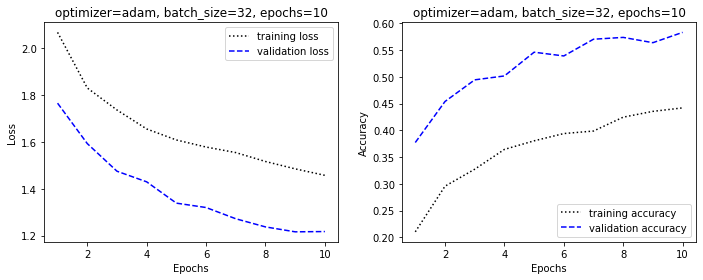

In [70]:
#第五步：繪圖
title = f"optimizer=adam, batch_size={batch_size}, epochs={epochs}"
plot_loss_acc(history.history, title=title)

In [71]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Saved trained model at /Volumes/Data/AI/homework/saved_models/keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 120s 12ms/step
Test loss: 1.2176128246307374
Test accuracy: 0.5832


# 作業 2 : 以同一模型, 分別驗證 SGD, Adam, Rmsprop 的 accurancy

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1801s 36ms/step - loss: 1.4467 - acc: 0.4499 - val_loss: 1.1530 - val_acc: 0.5992
Epoch 2/10
50000/50000 [==============================] - 1846s 37ms/step - loss: 1.4294 - acc: 0.4587 - val_loss: 1.1695 - val_acc: 0.5876
Epoch 3/10
50000/50000 [==============================] - 1580s 32ms/step - loss: 1.4298 - acc: 0.4547 - val_loss: 1.1424 - val_acc: 0.6021
Epoch 4/10
50000/50000 [==============================] - 1543s 31ms/step - loss: 1.4205 - acc: 0.4586 - val_loss: 1.1561 - val_acc: 0.5830
Epoch 5/10
50000/50000 [==============================] - 1554s 31ms/step - loss: 1.4188 - acc: 0.4606 - val_loss: 1.1450 - val_acc: 0.6119
Epoch 6/10
50000/50000 [==============================] - 1553s 31ms/step - loss: 1.4184 - acc: 0.4573 - val_loss: 1.1791 - val_acc: 0.5734
Epoch 7/10
50000/50000 [==============================] - 1562s 31ms/step - loss: 1.4512 - acc: 0.4517 - val_l

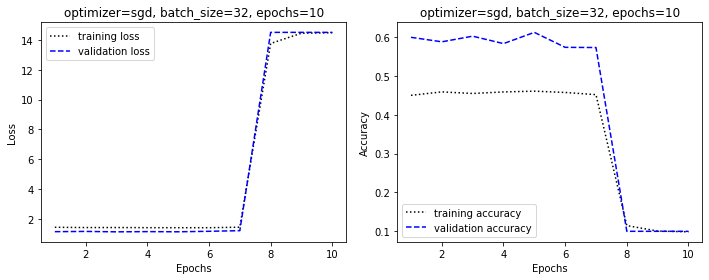

Saved trained model at /Volumes/Data/AI/homework/saved_models/keras_cifar10_trained_model.h5 
10000/10000 [==============================] - 118s 12ms/step
Test loss: 14.506285690307617
Test accuracy: 0.1


In [72]:
#SGD
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)   
title = f"optimizer=sgd, batch_size={batch_size}, epochs={epochs}"
plot_loss_acc(history.history, title=title)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
#Rmsprop
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)   
title = f"optimizer=rmsprop, batch_size={batch_size}, epochs={epochs}"
plot_loss_acc(history.history, title=title)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 1580s 32ms/step - loss: 14.5044 - acc: 0.0973 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 2/10
50000/50000 [==============================] - 1484s 30ms/step - loss: 14.4730 - acc: 0.0992 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 3/10
50000/50000 [==============================] - 1481s 30ms/step - loss: 14.4752 - acc: 0.0992 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 4/10
50000/50000 [==============================] - 1502s 30ms/step - loss: 14.4837 - acc: 0.0985 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 5/10
50000/50000 [==============================] - 1499s 30ms/step - loss: 14.4463 - acc: 0.1005 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 6/10
50000/50000 [==============================] - 1559s 31ms/step - loss: 14.4886 - acc: 0.0982 - val_loss: 14.5063 - val_acc: 0.1000
Epoch 7/10
50000/50000 [==============================] - 1529s 31ms/step - loss: 14.4287 - acc: 0

In [ ]:
 kmimik8 cm xikmjn hb